In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from sqlalchemy import (create_engine, inspect, func)

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
# Get a list of column names and types for measurement class
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Get a list of column names and types for station class 
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
#view a portion of the measurement table 
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [14]:
#view a portion of the station table 
engine.execute('SELECT * FROM Station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [15]:
#earliest date 
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01')

In [16]:
#latest date 
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [17]:
# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=360)
print("Query Date: ", query_date)

Query Date:  2016-08-28


## Exploratory Climate Analysis Vacation Dates: 

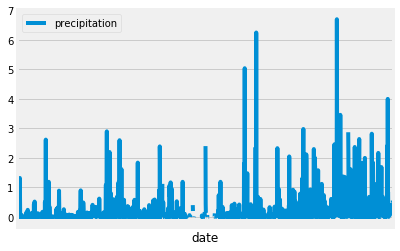

In [37]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Perform a query to retrieve the data and precipitation scores
pre_12 = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date > '2016-08-28').filter(Measurement.date<'2017-08-23').all()


# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(pre_12, columns = ['date','precipitation'])
df.set_index('date', inplace=True)


# Sort the dataframe by date
df.sort_values(by = 'date')


# Use Pandas Plotting with Matplotlib to plot the data
ax = df.plot.line(subplots=False)
ax.set_xticks([])
plt.show()

In [21]:
# Use Pandas to calculate the summary statistics for the precipitation data
sum_stats = df.describe()
sum_stats

,precipitation
count,1981.000000
mean,0.172463
std,0.453629
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [23]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(Station.station).count()
num_stations

9

In [24]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.id, Measurement.station).all()
df2 = pd.DataFrame(active_stations, columns = ['id', 'station'])
new_df2 = df2.groupby(['station']).count()['id'].sort_values(axis=0, ascending=False)
new_df2

station
USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: id, dtype: int64

In [25]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station=='USC00519281').all()
max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station=='USC00519281').all()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station=='USC00519281').all()
print(f'The minimum temp at Station USC00519281 is: {min_temp}')
print(f'The maximum temp at Station USC00519281 is: {max_temp}')
print(f'The average temp at Station USC00519281 is:{avg_temp}')

The minimum temp at Station USC00519281 is: [(54.0,)]
The maximum temp at Station USC00519281 is: [(85.0,)]
The average temp at Station USC00519281 is:[(71.66378066378067,)]


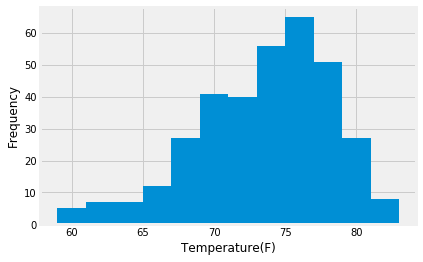

In [26]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_station = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station=='USC00519281').filter(Measurement.date > '2016-08-28').filter(Measurement.date<'2017-08-23').all()
df3 = pd.DataFrame(temp_station, columns = ['date','average temperature'])
df3.set_index('date', inplace=True)
#f3
#Prepare data to plot histogram
plt.hist(df3['average temperature'],12)
plt.xlabel('Temperature(F)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
